# Kuzushiji-MNIST Cas Kaggle APC
### Jordi González

# Introducción

MNIST "Modified National Institute of Standards and Technology", es el "Hola mundo" dentro de la vision por computador y el machine learning.

Este dataset consta de distintos carácteres Japoneses llamados hiragana.

Son imágenes de 28x28 píxeles, en escala de grises i clasificadas en 10 clases distintas.

# Objetivo

Este dataset nace de un paper [1], donde comparan técnicas de Machine Learning, en concreto el método de clasificación KNN, con tecnicas de Deep Learning.

Mi objetivo, además de hacer un estudio a fondo del dataset, es conseguir mejorar el "accuracy" del KNN que proponen en el paper, usando solamente técnicas de Machine Learning, para así dar un uso real a las diferentes técnicas que se han visto a lo largo del curso de "Aprendizaje Computacional", aplicándolas al caso de uso de la visión por computador.

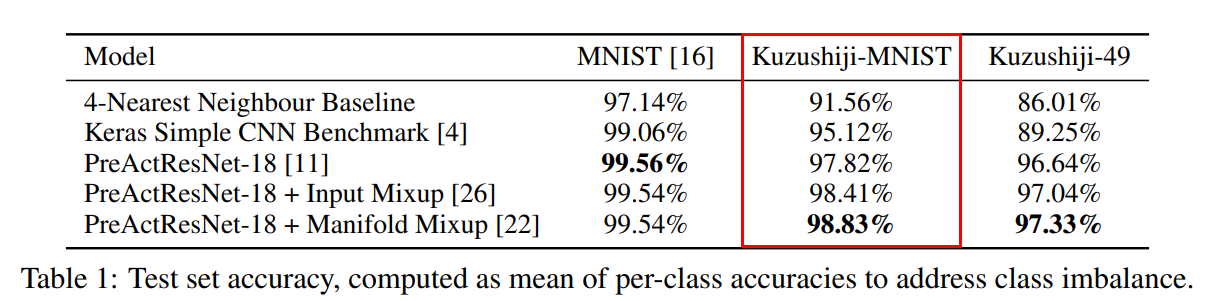

Como observamos en la tabla de resultados, el mejor "accuracy" obtenido para este dataset es de 91,56%.

# Código



In [5]:
# Esentials for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Macnine Learning clasifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Auxiliar functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy import ndimage

# Deep Learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet18, ResNet18_Weights

## 1. Lectura del dataset

In [9]:
train_images = np.load('data/kmnist-train-imgs.npz')['arr_0']
train_labels = np.load('data/kmnist-train-labels.npz')['arr_0']

El dataset está guardado en formato .npz (numpy). Ya nos dan los datos de train y los de test en diferentes ficheros, por lo que, no será necesario separar el dataset para tener las imágenes de test. 
Para seguir uno de los principios del entrenamiento con modelos, no miraremos en ningún momento los datos de test hasta tener uno o varios modelos creados. De esta manera evitaremos sobreajustar el modelo a los datos de test.

In [10]:
print('Train shape: ' + str(train_images.shape))
print('Train labels ' + str(train_labels.shape))

Train shape: (60000, 28, 28)
Train labels (60000,)


Las imágenes de train están compuestas de imágenes de 28x28 píxeles. Que hacen un total de 60000.

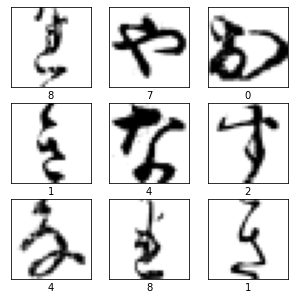

In [11]:
# Show the firt 9 images with their labels
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

Aquí vemos algunos ejemplos de distintos símbolos con su respectiva clase. A continuación, comprobaremos si el dataset está balanceado (probablemente, lo esté, ya que es similar a MNIST).

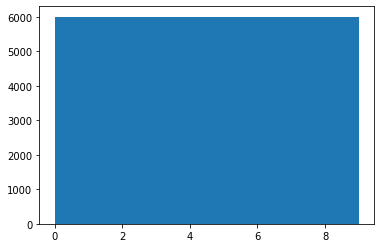

In [12]:
# Show class distribution
plt.hist(train_labels, bins=10)
plt.show()

En efecto, está balanceado. Como curiosidad vamos a comprobar la entropia de las letras. 
Así podemos ver si hay alguna clase que sea más complicada de escribir (más trazadas).

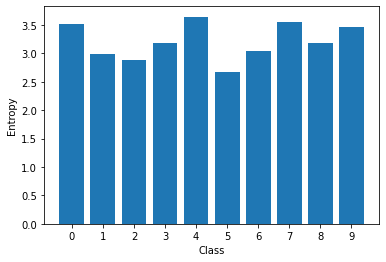

In [13]:
def entropy_of_image(image):
    """Calculate the entropy of an image"""
    hist, _ = np.histogram(image, bins=range(0, 257))
    hist = hist / np.sum(hist)
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))

# Calculate the entropy of each class
entropy = []
for i in range(10):
    mask = train_labels == i
    entropy.append(entropy_of_image(train_images[mask]))

# Plot the entropy of each class
plt.bar(range(10), entropy)
plt.xticks(range(10))
plt.xlabel('Class')
plt.ylabel('Entropy')
plt.show()

Como podemos observar, todas las clases tienen prácticamente la misma entropía, lo cual nos indica que todos los caracteres son igual de fáciles de trazar (o igual de difíciles...).

Realizado ya el análisis del dataset, buscaremos el mejor modelo para realizar una clasificación. Aunque, antes de esto, será necesario hacer la separación de algunas imágenes de los datos de train para poder validar el modelo.

## Reducción de dimensionalidad

Ya que estamos tratando con imágenes, es necesario reducir la dimensionalidad. Si no, el entrenamiento de los modelos puede demorarse mucho tiempo.

In [14]:
X_train_pca = np.reshape(train_images, (len(train_images), -1))/255

scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)

print(X_train_pca.shape)

pca = PCA(n_components=0.85)
X_train_pca = pca.fit_transform(X_train_pca)

print(X_train_pca.shape)

(60000, 784)
(60000, 126)


Pasamos de 784 características (28x28) a 126.

## Entrenamiento de los modelos

In [15]:
# Train/Vaidation split
X_train, X_val, y_train, y_val = train_test_split(X_train_pca, train_labels, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)

(48000, 126)
(12000, 126)


Una vez separado el dataset de train, dedicaremos 48000 imágenes a train y 12000 imágenes a test.

Ahora entrenaremos los siguientes modelos:
- SVM
- Random forest
- LogisticRegresion
- KNN
- MLPClassifier

In [16]:
# Train SVM
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

# Evaluate SVM
svm.score(X_val, y_val)

0.9585833333333333

Con SMV obtenemos un 95% de accuracy con los datos de validación. Es un muy buen modelo a tener en cuenta.

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Evaluate Random Forest
rf.score(X_val, y_val)

0.8569166666666667

Aun siendo Random Forest uno de los modelos más potentes, hemos visto que no es capaz de adaptarse bien a este tipo de datos. Entonces, probaremos aumentar el número de estimadores.

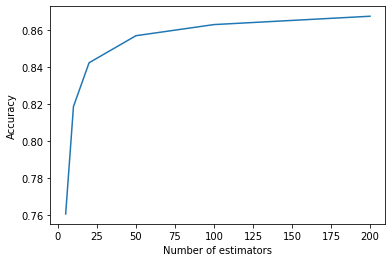

In [ ]:
estimators = [5, 10, 20, 50, 100, 200]
results = []

for n in estimators:
    rf = RandomForestClassifier(n_estimators=n, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)
    results.append(rf.score(X_val, y_val))

plt.plot(estimators, results)
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.show() 

A partir de los 100 estimadores, vemos que no mejora, por lo que el random forest queda descartado como candidato. 
Además es un modelo muy costoso de entrenar en comparación al KNN, por ejemplo.

In [ ]:
# Train Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Evaluate Logistic Regression
lr.score(X_val, y_val)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8229166666666666

Con Regresión logística obtenemos malos resultados también.


In [ ]:
# Train KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Evaluate KNN
knn.score(X_val, y_val)

0.9601666666666666

El KNN ha rendido excepcionalmente bien. Obteniendo el mejor resultado con un 96% de Accuracy (prácticamente el mismo que en el paper original, de momento nada nuevo). Aun así, probaremos un modelo sencillo MLP para ver la viabilidad del uso del Deep Learning en este problema de clasificación.

In [ ]:
# Train MLP
mlp = MLPClassifier(random_state=42,
    hidden_layer_sizes=(100, 100, 100))
    
mlp.fit(X_train, y_train)

# Evaluate MLP
mlp.score(X_val, y_val)

0.9538333333333333

Comprobamos que puede ser tan bueno como el KNN. Aun así, por el tiempo de entrenamiento tan largo que ha tenido, en comparación del KNN también lo descartamos.

## Data augmentation

Antes de empezar con el data augmentation, vamos a evaluar mejor el modelo KNN, para ver que clases son las que peor clasifica. Para ello, calcularemos la matriz de confusión. 

In [ ]:
# Plot the confusion matrix, and show the classification report
y_pred = knn.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)
print(classification_report(y_val, y_pred))

[[1120    2    4    6    7    5    1    1   16    5]
 [   3 1183    2    4    0    0    4    1    2    6]
 [   0   13 1146    5    2    2   21    0    3    8]
 [   4    8    8 1171    2    8    1    5    2    0]
 [  10   11   10    9 1090    0    5    0    7   13]
 [   3    4   14   27    1 1156    4    1    5    4]
 [   0    6   27   13    8    0 1129    2    2    4]
 [   5    4   11    7    7    3    0 1242    2   12]
 [   3   14    7    8    1    2    4    0 1152    3]
 [   3   13   12    0    3    0    0    1    2 1133]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1167
           1       0.94      0.98      0.96      1205
           2       0.92      0.95      0.94      1200
           3       0.94      0.97      0.95      1209
           4       0.97      0.94      0.96      1155
           5       0.98      0.95      0.97      1219
           6       0.97      0.95      0.96      1191
           7       0.99      0.96   

La clase 6, es la que peor resultado obtiene. Por lo que realizar un aumento de datos puede ser una buena idea, para que el modelo pueda generalizar mejor. La primera técnica que usaremos será aplicar desplazamientos horizontales y verticales a las imágenes, además de aplicarles rotaciones también.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

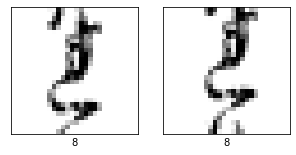

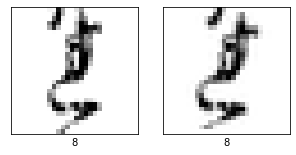

In [18]:
# Data augmentation

# Numpy jitter
def shifting_randomly(image, shift=3):
    """Shift the image randomly"""
    shift_x = np.random.randint(-shift, shift)
    shift_y = np.random.randint(-shift, shift)
    return np.roll(image, (shift_x, shift_y), axis=(0, 1))

def rotation_randomly(image, angle=15):
    """Rotate the image randomly"""
    angle = np.random.randint(-angle, angle)
    return ndimage.rotate(image, angle, reshape=False)

# Show 1 image before and after the jitter
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.xlabel(train_labels[0])
plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(shifting_randomly(train_images[0]), cmap=plt.cm.binary)
plt.xlabel(train_labels[0])
plt.show()

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.xlabel(train_labels[0])
plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(rotation_randomly(train_images[0]), cmap=plt.cm.binary)
plt.xlabel(train_labels[0])
plt.show()


Una vez que tenemos la función implementada vamos a crear unos datos de entrenamiento aumentados.

In [19]:
# Augment the training data
X_train_aug = []
y_train_aug = []

AUMENTATION = 3

for img, label in zip(X_train, y_train):
    for i in range(AUMENTATION):
        X_train_aug.append(rotation_randomly(img))
        y_train_aug.append(label)
    
    for i in range(AUMENTATION):
        X_train_aug.append(shifting_randomly(img))
        y_train_aug.append(label)

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

In [20]:
X_train_pca = np.reshape(X_train_aug, (len(X_train_aug), -1))/255

scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)

print(X_train_pca.shape)

pca = PCA(n_components=0.85)
X_train_pca = pca.fit_transform(X_train_pca)

print(X_train_pca.shape)

(288000, 784)
(288000, 122)


In [21]:
X_train_pca_val = np.reshape(X_val, (len(X_val), -1))/255

X_train_pca_val = scaler.transform(X_train_pca_val)

print(X_train_pca_val.shape)

X_train_pca_val = pca.transform(X_train_pca_val)

print(X_train_pca_val.shape)

(12000, 784)
(12000, 122)


In [ ]:
# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train_aug)

# Evaluate KNN
knn.score(X_train_pca_val, y_val)

0.9705833333333334

Bingo! Hemos pasado de un Accuracy del 96% al 97%.

## Fine-tunning

Teniendo el modelo adecuando y con el dataset aumentado, vemos a encontrar los mejores valores (hiperparámetros) para el KNN. Para ello, lo haremos con el dataset original, ya que puede tardar mucho tiempo.

In [ ]:
# Find the best KNN parameters
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train_aug)

# Evaluate KNN
grid_search.score(X_train_pca_val, y_val)

0.9716666666666667

In [ ]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

Los mejores parámetros són los que vienen por defecto y el número de K = 1.

## Test evaluation

Una vez tenemos los mejores parámetros para el modelo, lo podemos evaluar con los datos de test.

In [22]:
# Load test data
test_images = np.load('data/kmnist-test-imgs.npz')['arr_0']
test_labels = np.load('data/kmnist-test-labels.npz')['arr_0']

In [23]:
X_test_pca_val = np.reshape(test_images, (len(test_images), -1))/255

X_test_pca_val = scaler.transform(X_test_pca_val)

print(X_test_pca_val.shape)

X_test_pca_val = pca.transform(X_test_pca_val)

print(X_test_pca_val.shape)

(10000, 784)
(10000, 122)


Para evaluar finalmente el modelo, realizaremos un data aurmentation de todo el dataset de train (incluyendo los datos de validación).

In [24]:
# Test KNN model
# Train KNN
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn.fit(X_train_pca, y_train_aug)

# Evaluate KNN
knn.score(X_test_pca_val, test_labels)

0.9221

Objetivo conseguido! Hemos obtenido muy buenos resultados, superando al modelo de Machine Learning propuesto en el paper original.

In [26]:
# Plot the confusion matrix, and show the classification report
y_pred = knn.predict(X_test_pca_val)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
print(classification_report(test_labels, y_pred))

[[915   3   1   5   7  12   1  12  43   1]
 [  0 921  15   0   3   1  37   2  10  11]
 [  8   3 878  51   7   5  11   2  21  14]
 [  0   1  17 965   1   5   5   1   3   2]
 [ 15  11  11  18 889   4   7   3  31  11]
 [  1   8  39  16   1 914  13   0   5   3]
 [  1   3   9   9   5   1 969   0   2   1]
 [  4  12   5   4  12   2   4 911  25  21]
 [  2  13   7  25   1   0   5   1 945   1]
 [  6  15  20   9   3   3   4  11  15 914]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1000
           1       0.93      0.92      0.93      1000
           2       0.88      0.88      0.88      1000
           3       0.88      0.96      0.92      1000
           4       0.96      0.89      0.92      1000
           5       0.97      0.91      0.94      1000
           6       0.92      0.97      0.94      1000
           7       0.97      0.91      0.94      1000
           8       0.86      0.94      0.90      1000
           9       0.93     

## Trabajo a futuro

Como nuevo trabajo a posterior, podríamos probar el dataset con las clases no balanceadas que se presentan en el paper. 
Además de tambien usar técnicas mas relacionadas con el deep learning para la extracción de caracteristicas, como por ejemplo, las convoluciones y la reducción de dimensionalidad.


## Referencias

[1] https://arxiv.org/pdf/1812.01718v1.pdf (Paper oficial del dataset)  
[2] https://scikit-learn.org/ (Documentacion SKLearn)  
[3] https://www.kaggle.com/datasets/anokas/kuzushiji (Kaggle)  